In [1]:
from pathlib import Path
from polyquant.data.schema import load_schema
from polyquant.data.normalize import load_feature_scaler
from polyquant.data.datasets.tabular import TabularParquetIterable
import torch

ROOT = Path(r"C:\Users\nimro\PolyQuant")
DATASET_ROOT = ROOT / "data" / "features_dataset"
SCALER_PATH = DATASET_ROOT / "train_scaler.json"

schema = load_schema(DATASET_ROOT)
scaler = load_feature_scaler(SCALER_PATH, schema.feature_cols, schema.no_scale_cols)
ds = TabularParquetIterable(
    split_dir=DATASET_ROOT / "train",
    feature_cols=schema.feature_cols,
    scaler=scaler,
    batch_size=8192,
    shuffle_files=True,
    shuffle_rowgroup=True,
)

total = 0
pos = 0
for i, batch in enumerate(ds):
    y = batch["y"]
    total += y.numel()
    pos += int(y.sum())
    if total >= 500_000:  # enough
        break

print("positive rate ~", pos / total)


positive rate ~ 0.5141889080191144


In [2]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from polyquant.data.schema import load_schema
from polyquant.data.normalize import load_feature_scaler
from polyquant.data.datasets.tabular import TabularParquetIterable
from polyquant.models.mlp import MLP

ROOT = Path(r"C:\Users\nimro\PolyQuant")
DATASET_ROOT = ROOT / "data" / "features_dataset"
SCALER_PATH = DATASET_ROOT / "train_scaler.json"

schema = load_schema(DATASET_ROOT)
scaler = load_feature_scaler(SCALER_PATH, schema.feature_cols, schema.no_scale_cols)

ds = TabularParquetIterable(
    split_dir=DATASET_ROOT / "train",
    feature_cols=schema.feature_cols,
    scaler=scaler,
    batch_size=8192,
    shuffle_files=True,
    shuffle_rowgroup=True,
    seed=123,
)
loader = DataLoader(ds, batch_size=None, num_workers=0)

device = torch.device("cuda")
model = MLP(in_dim=len(schema.feature_cols)).to(device)
loss_fn = nn.BCEWithLogitsLoss()

batch = next(iter(loader))
x = batch["x"].to(device)
y = batch["y"].to(device)

with torch.no_grad():
    logits = model(x)
    loss = loss_fn(logits, y)

print("initial BCE (no training):", float(loss))


initial BCE (no training): 0.7049640417098999


Loaded price count: 69350435
0.00–0.01: 8874965
0.01–0.02: 1860982
0.02–0.03: 1115866
0.03–0.04: 829031
0.04–0.05: 600435
0.05–0.06: 657072
0.06–0.07: 471547
0.07–0.08: 375150
0.08–0.09: 433172
0.09–0.10: 308973
0.10–0.11: 444656
0.11–0.12: 352285
0.12–0.13: 367232
0.13–0.14: 339311
0.14–0.15: 327162
0.15–0.16: 326978
0.16–0.17: 380031
0.17–0.18: 319917
0.18–0.19: 330090
0.19–0.20: 262978
0.20–0.21: 427636
0.21–0.22: 325157
0.22–0.23: 333656
0.23–0.24: 320344
0.24–0.25: 283471
0.25–0.26: 453151
0.26–0.27: 376603
0.27–0.28: 371897
0.28–0.29: 407944
0.29–0.30: 360242
0.30–0.31: 443988
0.31–0.32: 299545
0.32–0.33: 452333
0.33–0.34: 594935
0.34–0.35: 694198
0.35–0.36: 272766
0.36–0.37: 576431
0.37–0.38: 502211
0.38–0.39: 541944
0.39–0.40: 382384
0.40–0.41: 900598
0.41–0.42: 254112
0.42–0.43: 474035
0.43–0.44: 466950
0.44–0.45: 504866
0.45–0.46: 564415
0.46–0.47: 812246
0.47–0.48: 228320
0.48–0.49: 630252
0.49–0.50: 625563
0.50–0.51: 1089689
0.51–0.52: 609541
0.52–0.53: 572883
0.53–0.54: 54

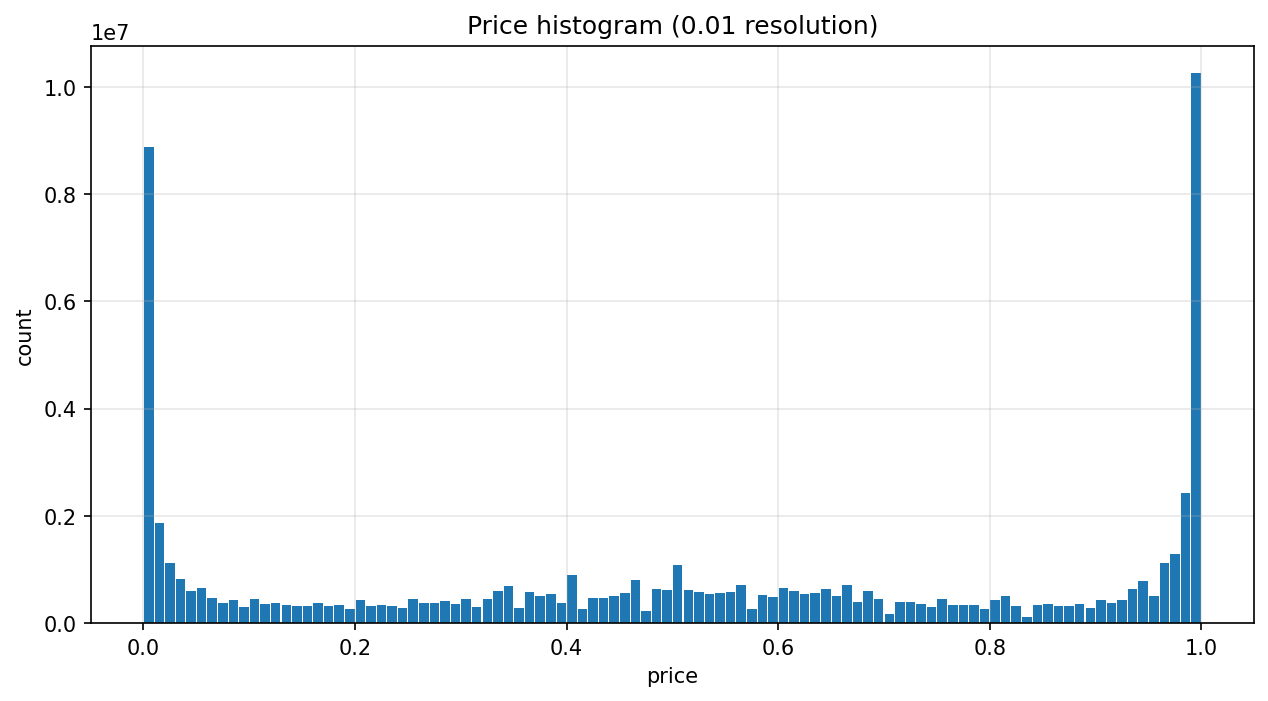

In [13]:
from pathlib import Path
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt

# Notebook is inside notebooks/, so go up one level
train_dir = Path("..") / "data" / "features_dataset" / "train"

files = sorted(train_dir.glob("*.parquet"))
if not files:
    raise FileNotFoundError("No parquet files found in train_dir")

prices = []

for fp in files:
    pf = pq.ParquetFile(fp)
    for rg in range(pf.num_row_groups):
        tbl = pf.read_row_group(rg, columns=["price"])
        arr = tbl.column("price").to_numpy(zero_copy_only=False)
        prices.append(arr)

prices = np.concatenate(prices)
print("Loaded price count:", prices.shape[0])

# ===========================
# Build 100 buckets 0.00–1.00
# ===========================
bins = np.linspace(0.0, 1.00, 101)    # 101 edges → 100 bins
counts, edges = np.histogram(prices, bins=bins)

# Print counts per bin
for i in range(len(counts)):
    lo = edges[i]
    hi = edges[i+1]
    print(f"{lo:0.2f}–{hi:0.2f}: {counts[i]}")

# ===========================
# Plot histogram
# ===========================
plt.figure(figsize=(10,5), dpi=150)
plt.bar((edges[:-1] + edges[1:]) / 2, counts, width=0.009)
plt.title("Price histogram (0.01 resolution)")
plt.xlabel("price")
plt.ylabel("count")
plt.grid(True, alpha=0.3)
plt.show()
